# Phishing Exploration & Classification 💻

### Content
This dataset contains 48 features extracted from 5000 phishing webpages and 5000 legitimate webpages, which were downloaded from January to May 2015 and from May to June 2017.

### Objective
Anti-phishing researchers and experts may find this dataset useful for phishing features analysis, conducting rapid proof of concept experiments or benchmarking phishing classification models.

# Data Collection

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE




## Importing dataset

In [26]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=19w3kNmDTZKrd2e83zTmFZW_2u7iuyfpk')

## Initial exploration

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 


From the total 50 rows we have `not found null values`. All of the columns are presented in `integers` and the first column `ID` will be excluded for ML modeling.

In [28]:
df.sample(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
19,20,1,0,4,59,0,0,0,0,0,...,0,0,0,1,0,1,1,1,-1,1
8351,8352,1,0,0,31,0,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0
9716,9717,2,1,3,44,1,1,0,0,0,...,0,0,0,1,1,1,0,0,1,0
7886,7887,1,0,2,62,7,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
2598,2599,4,0,2,39,0,0,0,0,0,...,1,0,0,1,1,-1,1,-1,-1,1


The sample shows coherent results. Lets proceed analyzing the outliers in each column

In [59]:
df.describe()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,0.073800,...,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,0.622248,...,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21.000000,14.000000,18.000000,253.000000,55.000000,9.000000,1.000000,1.000000,18.00000,19.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


At first sight we can identify some outliers in the database, a boxplot will help to identify those values

In [29]:
# plt.
# plt.boxplot(df["NumDots"])
# plt.show




# EDA

Creating Exploratory Data Analysis charts

In [30]:
df = df.iloc[:,1:]

In [54]:
nrows = math.ceil(len(df.columns) / 2)
ncols = 2

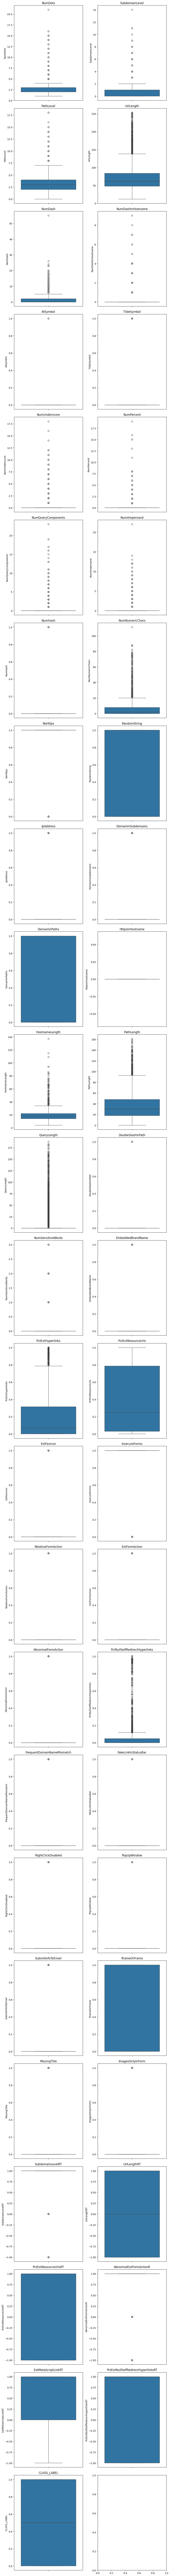

In [68]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,150])

for i, column in enumerate(df.columns):
    row = i // ncols
    col = i % 2
    sns.boxplot(df[column], ax=axes[row,col])
    axes[row,col].set_title(column)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()


The previous charts shows us typical values used when for some columns, it is also possible visualize boolean values and columns without outliers, we will keep this records since they may be key to identify phishing. Non categorical values were found.

 In order to proceed with the preprocessing 


# Feature Engineering

## Data Transformation
Not needed

## Correlations

Lets plot a correlation matrix to understand better the relationship between the characteristics and select the necessaries

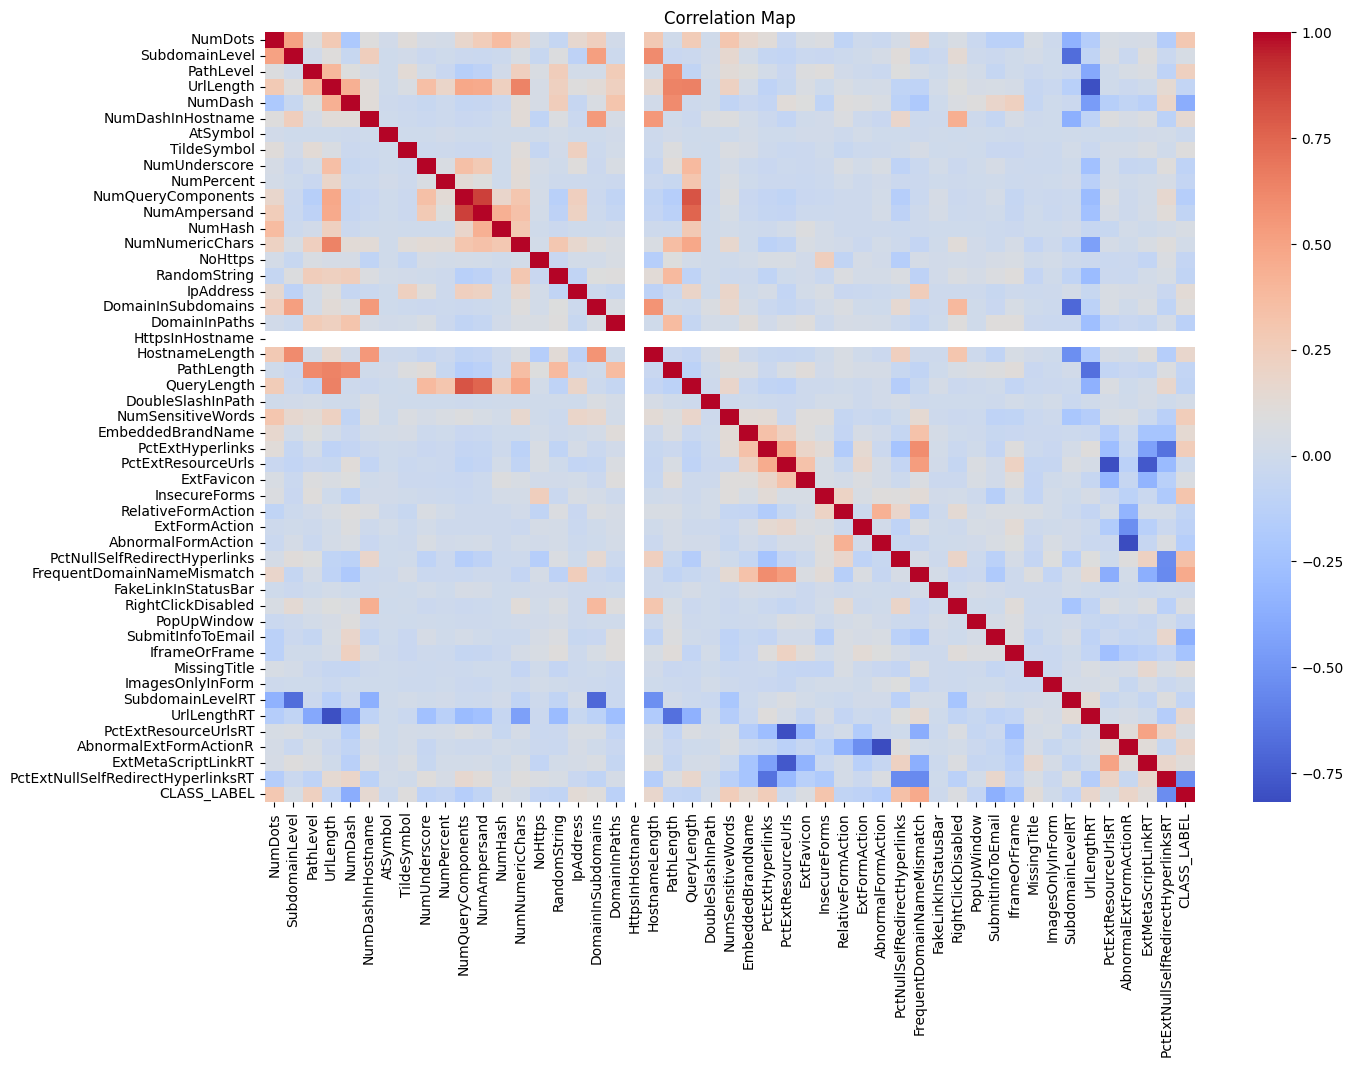

In [69]:
plt.figure(figsize=[15,10])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Map')
plt.show()

In [89]:
abs_correlations = abs(correlation_matrix['CLASS_LABEL']).sort_values(ascending=False).reset_index()
abs_correlations.head(10)

,index,CLASS_LABEL
0,CLASS_LABEL,1.000000
1,PctExtNullSelfRedirectHyperlinksRT,0.540545
2,FrequentDomainNameMismatch,0.463956
3,NumDash,0.372235
4,SubmitInfoToEmail,0.357635
5,PctNullSelfRedirectHyperlinks,0.342806
6,InsecureForms,0.316380
7,NumDots,0.294111
8,PctExtHyperlinks,0.259728
9,NumSensitiveWords,0.255208


## Feature Selection

In [91]:
selected_cols = abs_correlations[abs_correlations['CLASS_LABEL']>0.1]['index'].tolist()

# Model Training

We will train the model with 80% for training and 20% for testing.

In [137]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]


## Pipelines and Parameters

### Logistic Regression Parameters

In [121]:
lr_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000))
])

lr_param_grid = {
            'logreg__penalty': [ 'l1', 'l2', None],  # Regularización
            # 'logreg__C': [0.01, 0.1, 1, 10, 100],  # Fuerza de la regularización
            'logreg__solver': ['saga'], # ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algoritmo de optimización
            # 'logreg__l1_ratio': np.linspace(0, 1, 10)  # Solo si el solver es 'saga' y penalty es 'elasticnet'
        }


Light GBM Parameters

In [170]:
lgbm_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lightgbm', LGBMClassifier())
    ])

lgbm_param_grid = {
    'min_gain_to_split':[0.1],
    'lightgbm__max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'lightgbm__learning_rate': [0.1, 0.01, 0.001],  # Tasa de aprendizaje
    'lightgbm__n_estimators': [100, 500, 1000],  # Número de árboles en el bosque
    }
lgbm = ['LGBM',lgbm_pipeline,lgbm_param_grid]

In [165]:
def evaluate_model(y,y_pred):
    roc_auc = roc_auc_score(y,y_pred)
    return roc_auc

def train_model(X, y, pipeline, param_grid):
    '''This function will host the structure to run all the models, splitting the
    dataset, oversampling the data and returning the scores'''

    X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size=0.2, random_state=1234)

    # Oversampling
    smote = SMOTE(random_state=1234)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train) 

    # Training the model
    gs = GridSearchCV(pipeline, param_grid, cv=2, scoring='roc_auc', n_jobs=-1, verbose=2)
    gs.fit(X_train_resampled,y_train_resampled)

    # Scores
    best_score = gs.best_score_
    best_estimator = gs.best_estimator_
    
    # Testing Val
    pred_val = gs.predict_proba(X_val)[:,1]
    y_pred = gs.predict(X_val)
    score_val = evaluate_model(y_val,pred_val)
    
    print('______________________')
    print(f'Train AU-ROC Score: {best_score:.4f}')
    print(f'Test AU-ROC Score: {score_val:.4f}')
    print(f'Best Estimator: {best_estimator}', end='\n\n')
    print(classification_report(y_val, y_pred))
    
    
    # results = best_estimator, best_score, score_val 
    # return 
    # 


# Modeling Evaluation and Comparison

## Logistic Regression

In [166]:
train_model(X,y, lr_pipeline, lr_param_grid)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ............logreg__penalty=l2, logreg__solver=saga; total time=   1.9s
[CV] END ..........logreg__penalty=None, logreg__solver=saga; total time=   2.6s
[CV] END ............logreg__penalty=l1, logreg__solver=saga; total time=   2.9s
[CV] END ............logreg__penalty=l2, logreg__solver=saga; total time=   3.6s
[CV] END ..........logreg__penalty=None, logreg__solver=saga; total time=   4.5s
[CV] END ............logreg__penalty=l1, logreg__solver=saga; total time=   5.1s
______________________
Train AU-ROC Score: 0.9838
Test AU-ROC Score: 0.9827
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       996
           1       0.94      0.94      0.94      1004

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Best Estimator: Pipeline(steps=[('scale', StandardSc

## Light GBM

In [172]:
train_model(X,y, lgbm_pipeline, lgbm_param_grid)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


10216.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10216.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
10216.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10216.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00

[LightGBM] [Info] Number of positive: 2002, number of negative: 2002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 4004, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2002, number of negative: 2002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 4004, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2002, number of negative: 2002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

# Final Results

We got a final precision of 99.75% (AU-ROC Score) which is quite good for what are we looking for